In [2]:
import pandas as pd

df_large = pd.read_csv('botswana_bank_customer_churn.csv')
df_small = df_large.sample(n=10000, random_state=42) 
df_small.to_csv('botswana_bank_customer_churn_small.csv', index=False)

print(f"Размер уменьшен! Строк было: {len(df_large)}, стало: {len(df_small)}")

Размер уменьшен! Строк было: 115640, стало: 10000


In [7]:
import numpy as np
import pandas as pd
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')
VIZ_DIR = Path('../visualizations')
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Стек загружен. NumPy: {np.__version__}, Pandas: {pd.__version__}")

✅ Стек загружен. NumPy: 2.2.5, Pandas: 2.3.2


In [9]:
start_time = time.time()
df_churn = pd.read_csv('botswana_bank_customer_churn_small.csv', engine='c')

print(f"Dataset shape: {df_churn.shape}")
print(f"Memory usage: {df_churn.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"\nClass balance:\n{df_churn['Churn Flag'].value_counts(normalize=True)}")

# Выбор признаков
feature_cols = ['Income', 'Credit Score', 'Customer Tenure', 'Balance', 'NumOfProducts']
X = df_churn[feature_cols].values
y = df_churn['Churn Flag'].values

# Сплит со стратификацией (сохранение пропорций классов)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler(copy=False)
X_train_scaled = scaler.fit_transform(X_train.astype('float32'))
X_test_scaled = scaler.transform(X_test.astype('float32'))

print(f"Data preparation took: {time.time() - start_time:.4f}s")

Dataset shape: (10000, 25)
Memory usage: 5891.76 KB

Class balance:
Churn Flag
0    0.8797
1    0.1203
Name: proportion, dtype: float64
Data preparation took: 0.2000s


In [10]:
train_start = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
print(f"Training time: {time.time() - train_start:.4f}s")
print(classification_report(y_test, y_pred))

Training time: 0.0180s
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1759
           1       0.76      0.79      0.78       241

    accuracy                           0.94      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.95      0.94      0.95      2000



In [12]:
df_heart = pd.read_csv('heart_disease.csv')
df_heart['Target'] = df_heart['Heart Disease Status'].map({'No': 0, 'Yes': 1})
df_heart.dropna(subset=['Target', 'Age', 'Cholesterol Level', 'Blood Pressure', 'BMI'], inplace=True)

X_svm = df_heart[['Age', 'Blood Pressure', 'Cholesterol Level', 'BMI']].values
y_svm = df_heart['Target'].values

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm)

scaler_svm = StandardScaler()
X_train_s_scaled = scaler_svm.fit_transform(X_train_s.astype('float32'))
X_test_s_scaled = scaler_svm.transform(X_test_s.astype('float32'))

# Обучение SVM
svm_model = SVC(kernel='linear', random_state=42, cache_size=500)
svm_model.fit(X_train_s_scaled, y_train_s)
y_pred_svm = svm_model.predict(X_test_s_scaled)

print(f"Number of support vectors: {len(svm_model.support_vectors_)}")

Number of support vectors: 3193


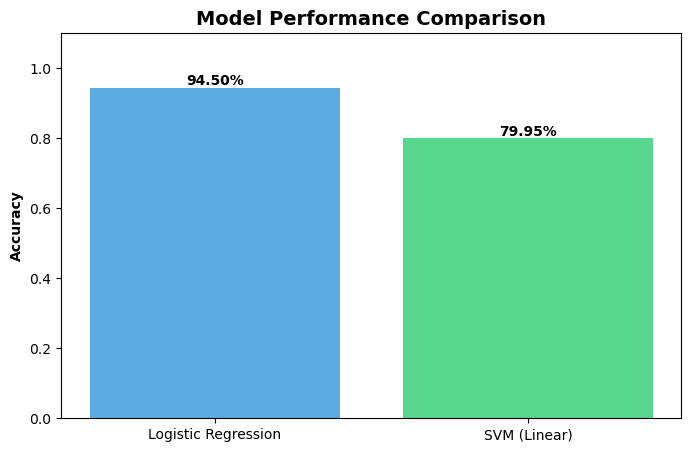

In [13]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (Linear)'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test_s, y_pred_svm)]
})

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'], color=['#3498db', '#2ecc71'], alpha=0.8)
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

plt.savefig(VIZ_DIR / 'model_comparison.png', bbox_inches='tight')
plt.show()